Debug the end-to-end optimization

In [1]:
import numpy as np

import scipy
from scipy.optimize import minimize
from scipy.stats import qmc
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error,root_mean_squared_error
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, MultiTaskElasticNetCV
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pyswarms as ps

from jax import grad
import jax.numpy as jnp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset,Subset

import optuna
import random

import pickle

Constructed padded numpy arrays

In [ ]:
training_cells = pd.read_csv("../Data_preprocessing/training.csv",header=None).to_numpy(dtype=str).reshape(-1,).tolist()
test_in_cells = pd.read_csv("../Data_preprocessing/test_in.csv",header=None).to_numpy(dtype=str).reshape(-1,).tolist()
test_out_cells = pd.read_csv("../Data_preprocessing/test_out.csv",header=None).to_numpy(dtype=str).reshape(-1,).tolist()

num_training_cells = len(training_cells)
num_test_in_cells = len(test_in_cells)
num_test_out_cells = len(test_out_cells)

a = np.loadtxt('../Empirical_model_fitting/Empirical_parameters_global_train_py.csv').item()


In [ ]:
X_train_PCA = np.loadtxt("Processed_input_output/X_train_PCA.csv",delimiter=",")
X_test_in_PCA = np.loadtxt("Processed_input_output/X_test_in_PCA.csv",delimiter=",")
X_test_out_PCA = np.loadtxt("Processed_input_output/X_test_out_PCA.csv",delimiter=",")

N_train = np.loadtxt("Processed_input_output/N_train.csv",delimiter=",")
N_test_in = np.loadtxt("Processed_input_output/N_test_in.csv",delimiter=",")
N_test_out = np.loadtxt("Processed_input_output/N_test_out.csv",delimiter=",")

Fit and transform feature using PCA

In [4]:
# Add intercept for end-to-end loss
X_train_PCA_1 = np.concatenate((np.ones((len(X_train_PCA),1)),X_train_PCA),axis=1)
X_test_in_PCA_1 = np.concatenate((np.ones((len(X_test_in_PCA),1)),X_test_in_PCA),axis=1)
X_test_out_PCA_1 = np.concatenate((np.ones((len(X_test_out_PCA),1)),X_test_out_PCA),axis=1)

Q_train = np.array([np.linspace(1,0.8,21)] * num_training_cells)
Q_test_in = np.array([np.linspace(1,0.8,21)] * num_test_in_cells)
Q_test_out = np.array([np.linspace(1,0.8,21)] * num_test_out_cells)

num_features = 10
param_bnd=(-10,10)
num_features_1 = 11

Define the empirical model

In [5]:
def empirical_model(global_p,b1,b2,b3,N_eq,b_weight=[1e-3,1e2,1e2]):
    a1 = global_p
    # Match the scaling for end-to-end formulation
    return 1 - b1*N_eq**a1*b_weight[0] - 1/(1+np.exp((b2*b_weight[1]-N_eq)/(b3*b_weight[2])))

## End-to-end elastic net

Define end-to-end objective function and empirical models for evaluation

In [97]:
# Two global power terms, four cell specific parameters.
def end_to_end_loss(W_,X,N,Q,a,alpha,rho): 
    # Without constraining the absolute values and add scaling for each X*wi
    n_features = X.shape[1]
    W = W_.reshape(n_features,3)
    len_interp = Q.shape[1]
    I_nm = np.ones_like(Q)
    I_1m = np.ones((1,len_interp))

    w1 = W[:,0].reshape(-1,1)
    w2 = W[:,1].reshape(-1,1)
    w3 = W[:,2].reshape(-1,1)

    # Terms inside the norm
    term_2 = X@w1@I_1m*1e-3 *  N**a
    term_3 = I_nm /( I_nm + np.exp(  (X@w2@I_1m*1e2 -N) / (X@w3@I_1m*1e2 ) ))

    loss_1 = np.mean(np.nanmean(np.array(I_nm - term_2 - term_3 - Q )**2,axis=1))
    loss_2 = np.sum(W[3:] ** 2) * 0.5 # L2 norm
    loss_3 = np.sum(np.abs(W[3:])) # L1 norm
    loss = loss_1 * 100 + alpha*(rho*loss_3 + (1-rho)*loss_2)
    return loss

Define nonlinear constraints

In [16]:
# Define three nonlinear constraints to ensure b1, b2, b3 are all positive
def g1(W_,X_):
    n_features = X_.shape[1]
    W = W_.reshape(n_features,3)
    w1 = W[:,0].reshape(-1,1)    
    
    X = np.mat(X_)
    # Terms inside the norm
    b1 = X*w1*1e-3
    return np.min(b1)

def g2(W_,X_):
    n_features = X_.shape[1]
    W = W_.reshape(n_features,3)
    X = np.mat(X_)
    w2 = W[:,1].reshape(-1,1)
    # Terms inside the norm
    b2 = X*w2*1e2
    return np.min(b2)

def g3(W_,X_):
    n_features = X_.shape[1]
    W = W_.reshape(n_features,3)
    X = np.mat(X_)
    w3 = W[:,2].reshape(-1,1)
    # Terms inside the norm
    b3 = X*w3*1e2
    return np.min(b3)

def visualize_opt_res(results):
    best_result = min(results, key=lambda x: x.fun)
    print(f"best MSE: {best_result.fun}")
    print(f"best W: {best_result.x}")

    obj_fun_values = [result.fun for result in results]
    s_or_f = np.array([result.success for result in results],dtype=int)
    fig,ax = plt.subplots(1,2,figsize=(6,2.5),dpi=100)
    ax[0].hist(obj_fun_values,bins=20, color='cornflowerblue', edgecolor='black')
    ax[0].set_xlabel('Objective function value')
    ax[0].set_ylabel('Frequency')

    ax[1].hist(s_or_f,color='cornflowerblue', edgecolor='black')
    ax[1].set_xlabel('Success/fail')
    ax[1].set_ylabel('Frequency')
    plt.tight_layout(pad=0.1)
    plt.show()
    return best_result

Run local optimization with random start

In [11]:
param_bnd = (-10,10)
# Multistart through Latin hypercube sampling
num_start = 100
sampler=qmc.LatinHypercube(d=num_features_1*3,seed=215)
sample = sampler.random(n=num_start)
lhs_lb = [param_bnd[0]+1e-2 for i in range(num_features_1*3)]
lhs_ub = [param_bnd[1]-1e-2 for i in range(num_features_1*3)]
sample_scaled = qmc.scale(sample,lhs_lb,lhs_ub)
method = 'SLSQP'


C:\Users\til22008\AppData\Local\Temp\ipykernel_27308\3869435058.py:27: RuntimeWarning: overflow encountered in exp
  term_3 = I_nm /( I_nm + np.exp(  (X@w2@I_1m*1e2 -N) / (X@w3@I_1m*1e2 ) ))


best MSE: 0.033594893404891246
best W: [ 7.03596188 10.          2.17241362  0.27174162  0.77326833  0.23650954
  0.0510283  -0.27769904 -0.08401794  0.21918617  0.81236529  0.32075319
 -0.46260189 -0.70659084 -0.12588964 -0.06982564  0.8400457   0.13436245
  0.43751592  0.81381628  0.09207146 -0.14281377  1.94144098  0.45387527
  0.38198891 -0.06284043 -0.04480064  0.17307805 -0.55467671  0.09347333
 -0.45320554  0.49346718  0.17628045]


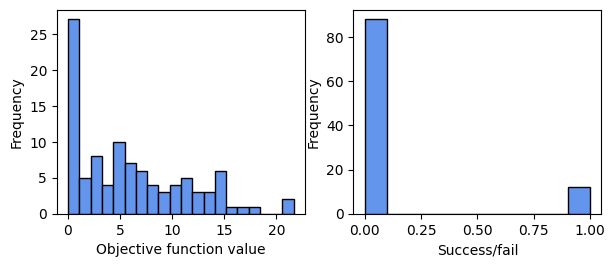

In [18]:
results = []

cons = [
    {'type':'ineq','fun':g1,'args':(X_train_PCA_1,)},
    {'type':'ineq','fun':g2,'args':(X_train_PCA_1,)},
    {'type':'ineq','fun':g3,'args':(X_train_PCA_1,)},
    ]

for i in range(len(sample_scaled)):
    # print(f'Iteration: {i+1}')
    W0 = sample_scaled[i]
    alpha = 1e-9
    rho = 0.95
    # Minimization
    res = minimize(end_to_end_loss,W0,
                   args = (X_train_PCA_1,N_train,Q_train,a,alpha,rho),
                   bounds = ((param_bnd, ) * len(W0)),
                   constraints = cons,
                   method = method,
                   options={'disp': False,'maxiter':500})
    results.append(res)

best_result = visualize_opt_res(results)

In [19]:
best_result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.033594893404891246
       x: [ 7.036e+00  1.000e+01 ...  4.935e-01  1.763e-01]
     nit: 173
     jac: [ 4.255e-05 -4.185e-04 ... -1.149e-04 -1.557e-04]
    nfev: 5920
    njev: 173

In [21]:
W_best_opt = best_result.x.reshape(num_features_1,3)
b_train_hat_e2e_eln = X_train_PCA_1@W_best_opt
b_test_in_hat_e2e_eln = X_test_in_PCA_1@W_best_opt
b_test_out_hat_e2e_eln = X_test_out_PCA_1@W_best_opt

# Evaluate training performance
Q_train_hat_e2e_eln = Q_train.copy()
RMSE_train_e2e_eln = []
MAE_train_ele_eln = []
for iii in range(len(Q_train)):
    Q_true = Q_train[iii]
    N_true = N_train[iii]
    [b1,b2,b3] = b_train_hat_e2e_eln[iii]
    Q_pred = empirical_model(a,b1,b2,b3,N_true)
    Q_train_hat_e2e_eln[iii] = Q_pred

    RMSE = root_mean_squared_error(Q_true,Q_pred)
    RMSE_train_e2e_eln.append(RMSE)
    MAE = mean_absolute_error(Q_true,Q_pred)
    MAE_train_ele_eln.append(MAE)

# Evaluate test performance
Q_test_in_hat_e2e_eln = Q_test_in.copy()
RMSE_test_in_e2e_eln = []
MAE_test_in_e2e_eln = []
for iii in range(len(Q_test_in)):
    Q_true = Q_test_in[iii]
    N_true = N_test_in[iii]
    [b1,b2,b3] = np.abs(b_test_in_hat_e2e_eln[iii])
    Q_pred = empirical_model(a,b1,b2,b3,N_true)
    Q_test_in_hat_e2e_eln[iii] = Q_pred

    RMSE = root_mean_squared_error(Q_true,Q_pred)
    RMSE_test_in_e2e_eln.append(RMSE)
    MAE = mean_absolute_error(Q_true,Q_pred)
    MAE_test_in_e2e_eln.append(MAE)

# Evaluate test performance
Q_test_out_hat_e2e_eln = Q_test_out.copy()
RMSE_test_out_e2e_eln = []
MAE_test_out_e2e_eln = []
for iii in range(len(Q_test_out)):
    Q_true = Q_test_out[iii]
    N_true = N_test_out[iii]
    [b1,b2,b3] = np.abs(b_test_out_hat_e2e_eln[iii])
    Q_pred = empirical_model(a,b1,b2,b3,N_true)
    Q_test_out_hat_e2e_eln[iii] = Q_pred

    RMSE = root_mean_squared_error(Q_true,Q_pred)
    RMSE_test_out_e2e_eln.append(RMSE)
    MAE = mean_absolute_error(Q_true,Q_pred)
    MAE_test_out_e2e_eln.append(MAE)


print(f'Mean RMSE Training: {np.mean(RMSE_train_e2e_eln)*100:.3f}%')
print(f'Mean RMSE High-DoD: {np.mean(RMSE_test_in_e2e_eln)*100:.3f}%')
print(f'Mean RMSE Low-DoD: {np.mean(RMSE_test_out_e2e_eln)*100:.3f}%')

print(f'Mean MAE Training: {np.mean(MAE_train_ele_eln)*100:.3f}%')
print(f'Mean MAE High-DoD: {np.mean(MAE_test_in_e2e_eln)*100:.3f}%')
print(f'Mean MAE Low-DoD: {np.mean(MAE_test_out_e2e_eln)*100:.3f}%')


Mean RMSE Training: 1.713%
Mean RMSE High-DoD: 2.464%
Mean RMSE Low-DoD: 4.394%
Mean MAE Training: 1.427%
Mean MAE High-DoD: 1.971%
Mean MAE Low-DoD: 3.774%


In [ ]:

b_train_pred_eln_df = pd.DataFrame(b_train_hat_e2e_eln * np.array([[1e-3,1e2,1e2]]*num_training_cells),index=training_cells)
b_test_in_pred_eln_df = pd.DataFrame(b_test_in_hat_e2e_eln * np.array([[1e-3,1e2,1e2]]*num_test_in_cells),index=test_in_cells)
b_test_out_pred_eln_df = pd.DataFrame(b_test_out_hat_e2e_eln * np.array([[1e-3,1e2,1e2]]*num_test_out_cells),index=test_out_cells)

# Save as csv files
b_train_pred_eln_df.to_csv("Empirical_parameter_results/b_train_e2e_eln.csv")
b_test_in_pred_eln_df.to_csv("Empirical_parameter_results/b_test_in_e2e_eln.csv")
b_test_out_pred_eln_df.to_csv("Empirical_parameter_results/b_test_out_e2e_eln.csv")

# End-to-end NN

In [6]:
seed_ = 42
random.seed(seed_)
torch.manual_seed(seed_)
np.random.seed(seed_)
torch.use_deterministic_algorithms(True)

In [7]:
with open('training_cells_CV.pkl','rb') as f:
    training_cells_CV = pickle.load(f)

with open('val_cells_CV.pkl','rb') as f:
    val_cells_CV = pickle.load(f)

train_dataset_CV = []
val_dataset_CV = []
for fold in range(10):
    train_cells = training_cells_CV[fold]
    val_cells = val_cells_CV[fold]

    X_train_fold = X_train_PCA[train_cells]
    X_val_fold = X_train_PCA[val_cells]
   
    Y_train_fold = N_train[train_cells]
    Y_val_fold = N_train[val_cells]
    # print(Y_val_fold)

    X_train_fold = torch.tensor(X_train_fold,dtype=torch.float32)
    X_val_fold = torch.tensor(X_val_fold,dtype=torch.float32)

    Y_train_fold = torch.tensor(Y_train_fold,dtype=torch.float32)
    Y_val_fold = torch.tensor(Y_val_fold,dtype=torch.float32)


    train_dataset = TensorDataset(X_train_fold,Y_train_fold)
    val_dataset = TensorDataset(X_val_fold,Y_val_fold)

    train_dataset_CV.append(train_dataset)
    val_dataset_CV.append(val_dataset)


In [8]:
# Define the network
class network(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(network, self).__init__()
        # Define the layers
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))  # Input layer
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))  # Hidden layers
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))  # Output layer
        self._initialize_weights()
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        # x = self.layers[-1](x)
        # x = torch.sigmoid(self.layers[-1](x))
        # x = torch.relu(self.layers[-1](x))
        x = torch.sigmoid(self.layers[-1](x)) * (40 - 1) + 1  # Outputs in range [1, 40]
        return x
    
    def _initialize_weights(self):
        for layer in self.layers[:-1]:
            if isinstance(layer, nn.Linear):
                torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')  # He Normal initialization
                if layer.bias is not None:
                    torch.nn.init.zeros_(layer.bias)  # Initialize bias to zero
        # Xavier Normal initialization for the output layer (sigmoid activation)
        torch.nn.init.xavier_normal_(self.layers[-1].weight)
        torch.nn.init.zeros_(self.layers[-1].bias)

        
# Define the early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Define the input size and output size
input_size = 10 # 10 pca features
output_size = 3 # 3 empirical model parameters

In [9]:
# Define the loss function informed by the empirical model
def end_to_end_loss_NN(output,target,a=0.5,b_weight=[1e-3,1e2,1e2]):
    # batch size and number of measurements
    (batch_size,len_interp) = target.size()
    # output size: (batch_size, n)
    b1 = output[:,0].unsqueeze(1)
    b2 = output[:,1].unsqueeze(1)
    b3 = output[:,2].unsqueeze(1)
    # Define ones
    I_nm = torch.ones_like(target,dtype=torch.float32)
    I_1m = torch.ones((1,len_interp),dtype=torch.float32)
    # Define Q
    Q = torch.linspace(1, 0.8, 21).unsqueeze(0).repeat(batch_size, 1)


    term_2 = b1*I_1m*b_weight[0] * target ** a
    term_3 = I_nm /( I_nm + torch.exp(  ((b2*I_1m*b_weight[1]) - target) / ((b3*I_1m)*b_weight[2] ) ))

    loss = torch.mean((I_nm - term_2 - term_3 - Q )**2)
    return loss

def end_to_end_loss_NN_new(output, target,a=0.5,b_weight=[1e-3,1e2,1e2]):  # Assuming `a` is a predefined value
    # batch size and number of measurements
    (batch_size, len_interp) = target.size()
    
    # output size: (batch_size, n)
    b1 = output[:, 0].unsqueeze(1)
    b2 = output[:, 1].unsqueeze(1)
    b3 = output[:, 2].unsqueeze(1)
    
    # Define ones
    I_nm = torch.ones_like(target, dtype=torch.float32)
    I_1m = torch.ones((1, len_interp), dtype=torch.float32)
    
    # Define Q
    Q = torch.linspace(1, 0.8, 21).unsqueeze(0).repeat(batch_size, 1)
    
    # Safe term_2 calculation
    term_2 = b1 * I_1m * b_weight[0] * torch.pow(target, a)  # Using torch.pow for stability
    
    # Clamp inputs to exp to avoid overflow/underflow
    exp_input = ((b2 * I_1m * b_weight[1]) - target) / ((b3 * I_1m * b_weight[2]) + 1e-6)
    exp_input_clamped = torch.clamp(exp_input, min = -87, max = 88) # The maximum range without causing overflow
    
    # Safe term_3 calculation with clamping
    term_3 = I_nm / (I_nm + torch.exp(exp_input_clamped))
    
    # Loss calculation
    loss = torch.mean((I_nm - term_2 - term_3 - Q) ** 2)
    
    return loss * 100



Perform hyperparameter optimization via optuna

In [ ]:
best_model_path = 'Best_network/best_e2e_model_V2.pth'  # File to save the best model
best_val_loss = float('inf')
b_weight = [5e-4,30,5]
# Hyperparameters to optimize: lr, # of neurons, # of layers
def objective(trial):
    global best_val_loss

    val_loss_CV = []
    model_state_dict = {}
    # Hyperparameter search space
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    num_neuron = trial.suggest_int('num_neuron', 5, 15)
    num_layer = trial.suggest_int('num_layer', 2, 5)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)

    hidden_sizes = [num_neuron] * num_layer  # Mapping
    num_epochs = 3000
    warmup_epochs = 150
    
    for fold in range(10):
        # Initialize the model, loss function, and optimizer
        model = network(input_size,hidden_sizes,output_size)
        criterion = end_to_end_loss_NN_new
        optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
        early_stopping = EarlyStopping(patience=30, min_delta=5e-6)

        # Load dataset for the current fold
        train_dataset = train_dataset_CV[fold]
        val_dataset = val_dataset_CV[fold]
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
        
        # Training loop
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            for batch in train_loader:
                inputs, labels = batch
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels,a, b_weight)
                loss.backward()
                optimizer.step()

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets, a, b_weight)
                    val_loss += loss.item()
            val_loss /= len(val_loader)

            # Check early stopping condition after warmup
            if epoch > warmup_epochs:
                early_stopping(val_loss)

            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break

        val_loss_CV.append(val_loss)
        model_state_dict[fold] = model.state_dict()

    val_loss_overall = np.mean(val_loss_CV)
    print(f"Validation loss: {val_loss_CV}")

    # Check if the current validation loss is the best
    if val_loss_overall < best_val_loss:
        best_val_loss = val_loss_overall
        # Save the best model
        torch.save({'model_state':model_state_dict,
                    'lr':lr,
                    'num_neuron':num_neuron,
                    'num_layer':num_layer,
                    'batch_size':batch_size,
                    'weight_decay':weight_decay}, best_model_path)

    return val_loss_overall


# Create an Optuna study
sampler = optuna.samplers.TPESampler(seed=seed_)  # Make the sampler deterministic
study = optuna.create_study(sampler=sampler, direction='minimize')

# Run the optimization
study.optimize(objective, n_trials=50)

# Print the best parameters
print("Best hyperparameters:", study.best_params)


[I 2024-10-30 16:27:22,001] A new study created in memory with name: no-name-513ab995-b112-4ece-b2df-0c6d071dfedc


Early stopping at epoch 186
Early stopping at epoch 190
Early stopping at epoch 182
Early stopping at epoch 182
Early stopping at epoch 257
Early stopping at epoch 182
Early stopping at epoch 307
Early stopping at epoch 182
Early stopping at epoch 197


[I 2024-10-30 16:27:42,648] Trial 0 finished with value: 1.0271456763148308 and parameters: {'lr': 0.0013292918943162175, 'num_neuron': 15, 'num_layer': 4, 'batch_size': 45, 'weight_decay': 4.2079886696066345e-06}. Best is trial 0 with value: 1.0271456763148308.


Early stopping at epoch 481
Validation loss: [0.1315794140100479, 7.4324564933776855, 0.902696430683136, 0.10137341171503067, 0.10704435408115387, 0.07484819740056992, 0.06394924223423004, 0.04294896125793457, 0.8142887353897095, 0.6002715229988098]
Early stopping at epoch 473
Early stopping at epoch 224
Early stopping at epoch 2105
Early stopping at epoch 1751
Early stopping at epoch 837
Early stopping at epoch 900
Early stopping at epoch 472
Early stopping at epoch 449
Early stopping at epoch 214


[I 2024-10-30 16:28:33,535] Trial 1 finished with value: 0.08515023961663246 and parameters: {'lr': 0.00029375384576328325, 'num_neuron': 5, 'num_layer': 5, 'batch_size': 45, 'weight_decay': 0.0006796578090758161}. Best is trial 1 with value: 0.08515023961663246.


Early stopping at epoch 243
Validation loss: [0.12132223695516586, 0.07766253501176834, 0.13073350489139557, 0.06593866646289825, 0.0702921524643898, 0.08586601912975311, 0.056703418493270874, 0.11062336713075638, 0.0732959657907486, 0.059064529836177826]
Early stopping at epoch 182
Early stopping at epoch 224
Early stopping at epoch 277
Early stopping at epoch 1597
Early stopping at epoch 334
Early stopping at epoch 196
Early stopping at epoch 456
Early stopping at epoch 277
Early stopping at epoch 202


[I 2024-10-30 16:29:19,195] Trial 2 finished with value: 0.13679461665451526 and parameters: {'lr': 0.00011527987128232407, 'num_neuron': 15, 'num_layer': 5, 'batch_size': 26, 'weight_decay': 5.337032762603957e-06}. Best is trial 1 with value: 0.08515023961663246.


Early stopping at epoch 243
Validation loss: [0.10130900144577026, 0.07493405789136887, 0.0904245674610138, 0.06209999695420265, 0.129887655377388, 0.05625500530004501, 0.34291547536849976, 0.10172905027866364, 0.21464377641677856, 0.19374758005142212]
Early stopping at epoch 713
Early stopping at epoch 325
Early stopping at epoch 435
Early stopping at epoch 801
Early stopping at epoch 224
Early stopping at epoch 437
Early stopping at epoch 1060
Early stopping at epoch 567
Early stopping at epoch 182


[I 2024-10-30 16:30:02,406] Trial 3 finished with value: 0.09656896702945232 and parameters: {'lr': 0.0003549878832196505, 'num_neuron': 8, 'num_layer': 4, 'batch_size': 37, 'weight_decay': 1.461896279370496e-05}. Best is trial 1 with value: 0.08515023961663246.


Early stopping at epoch 496
Validation loss: [0.11317719519138336, 0.09551075845956802, 0.061544496566057205, 0.0931231901049614, 0.09679768979549408, 0.056781962513923645, 0.08411350101232529, 0.24677105247974396, 0.05732250213623047, 0.060547322034835815]
Early stopping at epoch 182
Early stopping at epoch 183
Early stopping at epoch 183
Early stopping at epoch 200
Early stopping at epoch 223
Early stopping at epoch 272
Early stopping at epoch 203
Early stopping at epoch 229
Early stopping at epoch 182


[I 2024-10-30 16:30:19,991] Trial 4 finished with value: 0.15260736346244813 and parameters: {'lr': 0.006847920095574782, 'num_neuron': 6, 'num_layer': 3, 'batch_size': 33, 'weight_decay': 6.672367170464208e-05}. Best is trial 1 with value: 0.08515023961663246.


Early stopping at epoch 191
Validation loss: [0.07536094635725021, 0.08206716924905777, 0.8203577399253845, 0.09734486043453217, 0.06678547710180283, 0.05046502873301506, 0.0635671615600586, 0.04895578697323799, 0.07867377251386642, 0.14249569177627563]
Early stopping at epoch 186
Early stopping at epoch 198
Early stopping at epoch 216
Early stopping at epoch 184
Early stopping at epoch 182
Early stopping at epoch 277
Early stopping at epoch 186
Early stopping at epoch 238
Early stopping at epoch 187


[I 2024-10-30 16:30:35,674] Trial 5 finished with value: 0.07299568615853787 and parameters: {'lr': 0.0226739865237804, 'num_neuron': 7, 'num_layer': 4, 'batch_size': 45, 'weight_decay': 1.5339162591163623e-06}. Best is trial 5 with value: 0.07299568615853787.


Early stopping at epoch 248
Validation loss: [0.06675001233816147, 0.05115283280611038, 0.04222026467323303, 0.18953098356723785, 0.12244457751512527, 0.05409505218267441, 0.048009276390075684, 0.04311108961701393, 0.05665355175733566, 0.05598922073841095]
Early stopping at epoch 289
Early stopping at epoch 416
Early stopping at epoch 238
Early stopping at epoch 263
Early stopping at epoch 306
Early stopping at epoch 206
Early stopping at epoch 182
Early stopping at epoch 499
Early stopping at epoch 195


[I 2024-10-30 16:30:52,758] Trial 6 finished with value: 0.06957202926278114 and parameters: {'lr': 0.006647135865318032, 'num_neuron': 6, 'num_layer': 2, 'batch_size': 62, 'weight_decay': 0.007286653737491046}. Best is trial 6 with value: 0.06957202926278114.


Early stopping at epoch 273
Validation loss: [0.08204654604196548, 0.09337948262691498, 0.0782310739159584, 0.07235345244407654, 0.07635129988193512, 0.06246449798345566, 0.05845978856086731, 0.042678892612457275, 0.06312097609043121, 0.06663428246974945]
Early stopping at epoch 200
Early stopping at epoch 217
Early stopping at epoch 236
Early stopping at epoch 206
Early stopping at epoch 184
Early stopping at epoch 199
Early stopping at epoch 290
Early stopping at epoch 183
Early stopping at epoch 183


[I 2024-10-30 16:31:06,696] Trial 7 finished with value: 0.11003685034811497 and parameters: {'lr': 0.026619018884890575, 'num_neuron': 8, 'num_layer': 2, 'batch_size': 49, 'weight_decay': 5.762487216478604e-05}. Best is trial 6 with value: 0.06957202926278114.


Early stopping at epoch 182
Validation loss: [0.07566188275814056, 0.10327158868312836, 0.2104216068983078, 0.2350611835718155, 0.10446396470069885, 0.12208595871925354, 0.04922209680080414, 0.07759249210357666, 0.059985700994729996, 0.06260202825069427]
Early stopping at epoch 1166
Early stopping at epoch 1062
Early stopping at epoch 1725
Early stopping at epoch 1095
Early stopping at epoch 2658
Early stopping at epoch 2376
Early stopping at epoch 1606
Early stopping at epoch 914


[I 2024-10-30 16:32:32,550] Trial 8 finished with value: 0.0805358685553074 and parameters: {'lr': 0.00023233503515390126, 'num_neuron': 10, 'num_layer': 2, 'batch_size': 60, 'weight_decay': 1.0842262717330169e-05}. Best is trial 6 with value: 0.06957202926278114.


Early stopping at epoch 1726
Validation loss: [0.05513498932123184, 0.15216179192066193, 0.08566036075353622, 0.10487749427556992, 0.09243275225162506, 0.0567048154771328, 0.052727099508047104, 0.06597225368022919, 0.08276263624429703, 0.0569244921207428]
Early stopping at epoch 197
Early stopping at epoch 190
Early stopping at epoch 703
Early stopping at epoch 205
Early stopping at epoch 217
Early stopping at epoch 262
Early stopping at epoch 242
Early stopping at epoch 220
Early stopping at epoch 257


[I 2024-10-30 16:32:52,518] Trial 9 finished with value: 0.17686087414622306 and parameters: {'lr': 0.009717775305059635, 'num_neuron': 8, 'num_layer': 4, 'batch_size': 42, 'weight_decay': 5.4880470007660465e-06}. Best is trial 6 with value: 0.06957202926278114.


Early stopping at epoch 218
Validation loss: [0.07430867850780487, 0.07407091557979584, 0.026400160044431686, 0.09190292656421661, 1.023773193359375, 0.06665492802858353, 0.054186925292015076, 0.23469112813472748, 0.0676606148481369, 0.05495927110314369]
Early stopping at epoch 182
Early stopping at epoch 195
Early stopping at epoch 225
Early stopping at epoch 234
Early stopping at epoch 198
Early stopping at epoch 203
Early stopping at epoch 215
Early stopping at epoch 184
Early stopping at epoch 199


[I 2024-10-30 16:33:05,775] Trial 10 finished with value: 0.05996076874434948 and parameters: {'lr': 0.0732903453065306, 'num_neuron': 12, 'num_layer': 3, 'batch_size': 62, 'weight_decay': 0.008621541870304558}. Best is trial 10 with value: 0.05996076874434948.


Early stopping at epoch 244
Validation loss: [0.06676240265369415, 0.09209444373846054, 0.05346925929188728, 0.06736569851636887, 0.06380492448806763, 0.07460156828165054, 0.04315738007426262, 0.040700219571590424, 0.05728455260396004, 0.040367238223552704]
Early stopping at epoch 194
Early stopping at epoch 184
Early stopping at epoch 226
Early stopping at epoch 194
Early stopping at epoch 212
Early stopping at epoch 212
Early stopping at epoch 186
Early stopping at epoch 182
Early stopping at epoch 206


[I 2024-10-30 16:33:20,078] Trial 11 finished with value: 0.059244954586029054 and parameters: {'lr': 0.05320889423231188, 'num_neuron': 12, 'num_layer': 3, 'batch_size': 63, 'weight_decay': 0.009788450409471175}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 306
Validation loss: [0.06435614824295044, 0.10168595612049103, 0.04946873337030411, 0.06811335682868958, 0.05882742255926132, 0.06758475303649902, 0.0460389219224453, 0.04650545120239258, 0.04741344973444939, 0.04245535284280777]
Early stopping at epoch 212
Early stopping at epoch 182
Early stopping at epoch 214
Early stopping at epoch 215
Early stopping at epoch 187
Early stopping at epoch 184
Early stopping at epoch 217
Early stopping at epoch 222
Early stopping at epoch 186


[I 2024-10-30 16:33:33,820] Trial 12 finished with value: 0.06290958449244499 and parameters: {'lr': 0.09483778100691889, 'num_neuron': 12, 'num_layer': 3, 'batch_size': 56, 'weight_decay': 0.00946264497974616}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 208
Validation loss: [0.0725758820772171, 0.11807969212532043, 0.04353683441877365, 0.0698637142777443, 0.06351818889379501, 0.06522741168737411, 0.051998354494571686, 0.04835415631532669, 0.055402062833309174, 0.04053954780101776]
Early stopping at epoch 264
Early stopping at epoch 196
Early stopping at epoch 239
Early stopping at epoch 202
Early stopping at epoch 200
Early stopping at epoch 211
Early stopping at epoch 185
Early stopping at epoch 186
Early stopping at epoch 204


[I 2024-10-30 16:33:47,521] Trial 13 finished with value: 0.09182655215263366 and parameters: {'lr': 0.0778780188885582, 'num_neuron': 12, 'num_layer': 3, 'batch_size': 56, 'weight_decay': 0.0010280147799031692}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 188
Validation loss: [0.08396917581558228, 0.15089663863182068, 0.04043940082192421, 0.1450318992137909, 0.07645333558320999, 0.057765983045101166, 0.06379619240760803, 0.0432625375688076, 0.08627167344093323, 0.1703786849975586]
Early stopping at epoch 266
Early stopping at epoch 208
Early stopping at epoch 235
Early stopping at epoch 183
Early stopping at epoch 219
Early stopping at epoch 219
Early stopping at epoch 219
Early stopping at epoch 187
Early stopping at epoch 199


[I 2024-10-30 16:34:14,515] Trial 14 finished with value: 0.07946799658238887 and parameters: {'lr': 0.033371299037816805, 'num_neuron': 12, 'num_layer': 3, 'batch_size': 20, 'weight_decay': 0.0012237594247191323}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 187
Validation loss: [0.06566549092531204, 0.19243745505809784, 0.03233259916305542, 0.08574805408716202, 0.06669913977384567, 0.05924639478325844, 0.09453244507312775, 0.09157564491033554, 0.05279545485973358, 0.05364728718996048]
Early stopping at epoch 730
Early stopping at epoch 182
Early stopping at epoch 643
Early stopping at epoch 209
Early stopping at epoch 357
Early stopping at epoch 214
Early stopping at epoch 327
Early stopping at epoch 266
Early stopping at epoch 195


[I 2024-10-30 16:34:35,194] Trial 15 finished with value: 0.656513973325491 and parameters: {'lr': 0.0018561860486787612, 'num_neuron': 13, 'num_layer': 3, 'batch_size': 64, 'weight_decay': 0.0033762283403411197}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 298
Validation loss: [0.18905048072338104, 5.301029205322266, 0.18667687475681305, 0.08902163803577423, 0.07452427595853806, 0.05595709756016731, 0.45971059799194336, 0.12202025204896927, 0.06024252623319626, 0.026906784623861313]
Early stopping at epoch 193
Early stopping at epoch 184
Early stopping at epoch 219
Early stopping at epoch 205
Early stopping at epoch 207
Early stopping at epoch 188
Early stopping at epoch 204
Early stopping at epoch 216
Early stopping at epoch 237


[I 2024-10-30 16:34:47,401] Trial 16 finished with value: 0.111894516274333 and parameters: {'lr': 0.04122012482760306, 'num_neuron': 10, 'num_layer': 2, 'batch_size': 51, 'weight_decay': 0.00023108579821866317}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 226
Validation loss: [0.05146710202097893, 0.10887330770492554, 0.13480471074581146, 0.06350913643836975, 0.08181966841220856, 0.08974432945251465, 0.050413601100444794, 0.3994828462600708, 0.07523243874311447, 0.06359802186489105]
Early stopping at epoch 185
Early stopping at epoch 213
Early stopping at epoch 234
Early stopping at epoch 183
Early stopping at epoch 201
Early stopping at epoch 190
Early stopping at epoch 250
Early stopping at epoch 191
Early stopping at epoch 182


[I 2024-10-30 16:35:01,382] Trial 17 finished with value: 0.136982698738575 and parameters: {'lr': 0.011389740369231415, 'num_neuron': 13, 'num_layer': 3, 'batch_size': 55, 'weight_decay': 0.0026498961874338134}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 208
Validation loss: [0.21488717198371887, 0.0662737786769867, 0.06552577018737793, 0.3043577969074249, 0.3288840055465698, 0.09052293002605438, 0.060891274362802505, 0.135724738240242, 0.06875913590192795, 0.03400038555264473]
Early stopping at epoch 212
Early stopping at epoch 201
Early stopping at epoch 220
Early stopping at epoch 188
Early stopping at epoch 187
Early stopping at epoch 207
Early stopping at epoch 235
Early stopping at epoch 182
Early stopping at epoch 195


[I 2024-10-30 16:35:16,152] Trial 18 finished with value: 0.07886622175574302 and parameters: {'lr': 0.05181975512011711, 'num_neuron': 11, 'num_layer': 4, 'batch_size': 64, 'weight_decay': 0.00033596824144542867}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 183
Validation loss: [0.0542217455804348, 0.1094016581773758, 0.03868504613637924, 0.11465795338153839, 0.11254950612783432, 0.047329969704151154, 0.08098477870225906, 0.13247798383235931, 0.047666870057582855, 0.050686705857515335]
Early stopping at epoch 249
Early stopping at epoch 523
Early stopping at epoch 240
Early stopping at epoch 182
Early stopping at epoch 1068
Early stopping at epoch 200
Early stopping at epoch 1406
Early stopping at epoch 186
Early stopping at epoch 588


[I 2024-10-30 16:35:45,762] Trial 19 finished with value: 0.6723136950284243 and parameters: {'lr': 0.0033192649217672256, 'num_neuron': 14, 'num_layer': 2, 'batch_size': 52, 'weight_decay': 0.003274664472073347}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 738
Validation loss: [0.0791550874710083, 6.009213447570801, 0.03940689191222191, 0.09263925999403, 0.06541959196329117, 0.06657566875219345, 0.054536446928977966, 0.18848121166229248, 0.07789343595504761, 0.04981590807437897]
Early stopping at epoch 182
Early stopping at epoch 184
Early stopping at epoch 188
Early stopping at epoch 202
Early stopping at epoch 248
Early stopping at epoch 213
Early stopping at epoch 272
Early stopping at epoch 230
Early stopping at epoch 193


[I 2024-10-30 16:35:59,230] Trial 20 finished with value: 0.07046094201505185 and parameters: {'lr': 0.016560905214446857, 'num_neuron': 10, 'num_layer': 3, 'batch_size': 59, 'weight_decay': 0.008296546993839084}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 246
Validation loss: [0.07629092782735825, 0.12131491303443909, 0.051561761647462845, 0.10181799530982971, 0.08012279123067856, 0.0775483250617981, 0.0563189797103405, 0.04093170166015625, 0.05969993770122528, 0.03900208696722984]
Early stopping at epoch 182
Early stopping at epoch 239
Early stopping at epoch 238
Early stopping at epoch 183
Early stopping at epoch 268
Early stopping at epoch 212
Early stopping at epoch 193
Early stopping at epoch 261
Early stopping at epoch 198


[I 2024-10-30 16:36:13,330] Trial 21 finished with value: 0.06628813594579697 and parameters: {'lr': 0.07973419605186383, 'num_neuron': 12, 'num_layer': 3, 'batch_size': 57, 'weight_decay': 0.00882660286434854}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 198
Validation loss: [0.08106102049350739, 0.16593557596206665, 0.03467947244644165, 0.06633221358060837, 0.06691426783800125, 0.0677613839507103, 0.048678919672966, 0.04027924686670303, 0.051742617040872574, 0.03949664160609245]
Early stopping at epoch 205
Early stopping at epoch 188
Early stopping at epoch 215
Early stopping at epoch 225
Early stopping at epoch 339
Early stopping at epoch 208
Early stopping at epoch 202
Early stopping at epoch 205
Early stopping at epoch 252


[I 2024-10-30 16:36:28,557] Trial 22 finished with value: 0.07763646878302097 and parameters: {'lr': 0.09454666095702148, 'num_neuron': 11, 'num_layer': 3, 'batch_size': 54, 'weight_decay': 0.0021366574250801696}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 219
Validation loss: [0.10068017244338989, 0.08466611057519913, 0.0640370100736618, 0.08571566641330719, 0.16146549582481384, 0.050112854689359665, 0.07291296124458313, 0.04824434965848923, 0.06130778789520264, 0.04722227901220322]
Early stopping at epoch 188
Early stopping at epoch 195
Early stopping at epoch 193
Early stopping at epoch 214
Early stopping at epoch 271
Early stopping at epoch 208
Early stopping at epoch 182
Early stopping at epoch 182
Early stopping at epoch 183


[I 2024-10-30 16:36:43,824] Trial 23 finished with value: 0.06379643976688384 and parameters: {'lr': 0.05062164720943311, 'num_neuron': 13, 'num_layer': 3, 'batch_size': 59, 'weight_decay': 0.004374111838811446}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 382
Validation loss: [0.07085254788398743, 0.12292160093784332, 0.047979071736335754, 0.054639268666505814, 0.07162220776081085, 0.04744257777929306, 0.06873004883527756, 0.04906307905912399, 0.07202228158712387, 0.03269171342253685]
Early stopping at epoch 226
Early stopping at epoch 189
Early stopping at epoch 224
Early stopping at epoch 342
Early stopping at epoch 211
Early stopping at epoch 206
Early stopping at epoch 227
Early stopping at epoch 217
Early stopping at epoch 186


[I 2024-10-30 16:36:58,951] Trial 24 finished with value: 0.0813774086534977 and parameters: {'lr': 0.09976865637630772, 'num_neuron': 11, 'num_layer': 4, 'batch_size': 49, 'weight_decay': 0.0003947453425515755}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 184
Validation loss: [0.07175444066524506, 0.19354024529457092, 0.059701547026634216, 0.07061316072940826, 0.06246031075716019, 0.05635103955864906, 0.051023006439208984, 0.12266548722982407, 0.059626709669828415, 0.06603813916444778]
Early stopping at epoch 220
Early stopping at epoch 183
Early stopping at epoch 238
Early stopping at epoch 207
Early stopping at epoch 182
Early stopping at epoch 199
Early stopping at epoch 185
Early stopping at epoch 187
Early stopping at epoch 182


[I 2024-10-30 16:37:12,436] Trial 25 finished with value: 0.13162030931562185 and parameters: {'lr': 0.017200725193754856, 'num_neuron': 14, 'num_layer': 3, 'batch_size': 64, 'weight_decay': 0.0014857781035037209}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 200
Validation loss: [0.08834598958492279, 0.08664398640394211, 0.018615910783410072, 0.3375689387321472, 0.21215450763702393, 0.05380659177899361, 0.09715016931295395, 0.2904994487762451, 0.06435592472553253, 0.06706162542104721]
Early stopping at epoch 196
Early stopping at epoch 235
Early stopping at epoch 223
Early stopping at epoch 232
Early stopping at epoch 208
Early stopping at epoch 185
Early stopping at epoch 190
Early stopping at epoch 213
Early stopping at epoch 247


[I 2024-10-30 16:37:26,444] Trial 26 finished with value: 0.0628313485532999 and parameters: {'lr': 0.04940452771292392, 'num_neuron': 9, 'num_layer': 2, 'batch_size': 60, 'weight_decay': 0.009519029611951639}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 235
Validation loss: [0.07768984138965607, 0.12062283605337143, 0.055620063096284866, 0.062391020357608795, 0.05504516884684563, 0.055064063519239426, 0.05318659171462059, 0.05040968582034111, 0.06177538260817528, 0.03650883212685585]
Early stopping at epoch 230
Early stopping at epoch 236
Early stopping at epoch 233
Early stopping at epoch 183
Early stopping at epoch 283
Early stopping at epoch 187
Early stopping at epoch 188
Early stopping at epoch 218
Early stopping at epoch 182


[I 2024-10-30 16:37:39,644] Trial 27 finished with value: 0.06832930967211723 and parameters: {'lr': 0.04824994745039456, 'num_neuron': 9, 'num_layer': 2, 'batch_size': 60, 'weight_decay': 0.005133811313556047}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 199
Validation loss: [0.06920313090085983, 0.08642140030860901, 0.03288641571998596, 0.14423923194408417, 0.05952741950750351, 0.0646001473069191, 0.08534541726112366, 0.0445704460144043, 0.054796453565359116, 0.041703034192323685]
Early stopping at epoch 182
Early stopping at epoch 214
Early stopping at epoch 187
Early stopping at epoch 185
Early stopping at epoch 232
Early stopping at epoch 182
Early stopping at epoch 228
Early stopping at epoch 209
Early stopping at epoch 187


[I 2024-10-30 16:38:02,257] Trial 28 finished with value: 0.12594905197620393 and parameters: {'lr': 0.028106081734476488, 'num_neuron': 9, 'num_layer': 2, 'batch_size': 17, 'weight_decay': 0.00011733032154342641}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 196
Validation loss: [0.2577766180038452, 0.18800416588783264, 0.05858646333217621, 0.14986425638198853, 0.07573742419481277, 0.07545431703329086, 0.09569567441940308, 0.22525174915790558, 0.0894804447889328, 0.0436394065618515]
Early stopping at epoch 439
Early stopping at epoch 1230
Early stopping at epoch 292
Early stopping at epoch 312
Early stopping at epoch 249
Early stopping at epoch 381
Early stopping at epoch 448
Early stopping at epoch 386
Early stopping at epoch 211


[I 2024-10-30 16:38:34,087] Trial 29 finished with value: 0.09709901288151741 and parameters: {'lr': 0.000904123563299114, 'num_neuron': 9, 'num_layer': 2, 'batch_size': 33, 'weight_decay': 0.0005740529284690341}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 564
Validation loss: [0.06617432832717896, 0.18020929396152496, 0.20370331406593323, 0.10524361580610275, 0.07209272682666779, 0.05210287123918533, 0.06732115149497986, 0.07093379646539688, 0.07418312877416611, 0.07902590185403824]
Early stopping at epoch 346
Early stopping at epoch 243
Early stopping at epoch 213
Early stopping at epoch 222
Early stopping at epoch 190
Early stopping at epoch 193
Early stopping at epoch 184
Early stopping at epoch 185
Early stopping at epoch 183


[I 2024-10-30 16:38:49,952] Trial 30 finished with value: 0.10073035396635532 and parameters: {'lr': 0.004931798253010885, 'num_neuron': 11, 'num_layer': 5, 'batch_size': 48, 'weight_decay': 0.0019398418176312191}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 198
Validation loss: [0.048325393348932266, 0.24722513556480408, 0.06954903155565262, 0.11869698017835617, 0.1664307713508606, 0.06272917240858078, 0.10827723890542984, 0.07466917484998703, 0.05719508230686188, 0.05420555919408798]
Early stopping at epoch 197
Early stopping at epoch 196
Early stopping at epoch 205
Early stopping at epoch 182
Early stopping at epoch 182
Early stopping at epoch 183
Early stopping at epoch 193
Early stopping at epoch 182
Early stopping at epoch 191


[I 2024-10-30 16:39:03,021] Trial 31 finished with value: 0.0721618089824915 and parameters: {'lr': 0.06751401957118125, 'num_neuron': 12, 'num_layer': 3, 'batch_size': 57, 'weight_decay': 0.005528877101114343}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 187
Validation loss: [0.09934494644403458, 0.10596556961536407, 0.06773589551448822, 0.11244308203458786, 0.06357304751873016, 0.06259353458881378, 0.06467077881097794, 0.04014870151877403, 0.05669607222080231, 0.04844646155834198]
Early stopping at epoch 194
Early stopping at epoch 182
Early stopping at epoch 186
Early stopping at epoch 207
Early stopping at epoch 184
Early stopping at epoch 184
Early stopping at epoch 212
Early stopping at epoch 190
Early stopping at epoch 206


[I 2024-10-30 16:39:16,569] Trial 32 finished with value: 0.05989247150719166 and parameters: {'lr': 0.03865773102021936, 'num_neuron': 14, 'num_layer': 3, 'batch_size': 61, 'weight_decay': 0.008670683177197418}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 233
Validation loss: [0.06915513426065445, 0.0926944836974144, 0.05974246934056282, 0.07076486200094223, 0.06308283656835556, 0.054118987172842026, 0.04649817571043968, 0.0457768514752388, 0.06137348711490631, 0.0357174277305603]
Early stopping at epoch 190
Early stopping at epoch 189
Early stopping at epoch 189
Early stopping at epoch 183
Early stopping at epoch 190
Early stopping at epoch 265
Early stopping at epoch 199
Early stopping at epoch 299
Early stopping at epoch 187


[I 2024-10-30 16:39:31,354] Trial 33 finished with value: 0.07610781863331795 and parameters: {'lr': 0.017823473556851425, 'num_neuron': 15, 'num_layer': 4, 'batch_size': 60, 'weight_decay': 0.004577630870380299}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 197
Validation loss: [0.06880684196949005, 0.14327357709407806, 0.026364680379629135, 0.12201782315969467, 0.061542801558971405, 0.04948228597640991, 0.07136986404657364, 0.051860399544239044, 0.1085638552904129, 0.05779605731368065]
Early stopping at epoch 204
Early stopping at epoch 354
Early stopping at epoch 202
Early stopping at epoch 184
Early stopping at epoch 223
Early stopping at epoch 223
Early stopping at epoch 191
Early stopping at epoch 199
Early stopping at epoch 212


[I 2024-10-30 16:39:44,549] Trial 34 finished with value: 0.0691367469727993 and parameters: {'lr': 0.04299046550321034, 'num_neuron': 14, 'num_layer': 2, 'batch_size': 62, 'weight_decay': 0.001008306352774215}. Best is trial 11 with value: 0.059244954586029054.


Early stopping at epoch 264
Validation loss: [0.05724276602268219, 0.14826950430870056, 0.02604086697101593, 0.06254477053880692, 0.04531096667051315, 0.11154890805482864, 0.0953824371099472, 0.04428011551499367, 0.049040455371141434, 0.05170667916536331]
Early stopping at epoch 326
Early stopping at epoch 188
Early stopping at epoch 244
Early stopping at epoch 199
Early stopping at epoch 261
Early stopping at epoch 185
Early stopping at epoch 183
Early stopping at epoch 332
Early stopping at epoch 205


[I 2024-10-30 16:39:59,334] Trial 35 finished with value: 0.05658496543765068 and parameters: {'lr': 0.01076070745576319, 'num_neuron': 13, 'num_layer': 3, 'batch_size': 53, 'weight_decay': 0.009712546959747659}. Best is trial 35 with value: 0.05658496543765068.


Early stopping at epoch 200
Validation loss: [0.06939304620027542, 0.09079958498477936, 0.03191123157739639, 0.06117204949259758, 0.06077929958701134, 0.056935131549835205, 0.0525105856359005, 0.04924936220049858, 0.05227411165833473, 0.0408252514898777]
Early stopping at epoch 203
Early stopping at epoch 213
Early stopping at epoch 214
Early stopping at epoch 182
Early stopping at epoch 190
Early stopping at epoch 195
Early stopping at epoch 199
Early stopping at epoch 182
Early stopping at epoch 193


[I 2024-10-30 16:40:12,737] Trial 36 finished with value: 0.09824063684791326 and parameters: {'lr': 0.012229134189967628, 'num_neuron': 14, 'num_layer': 3, 'batch_size': 53, 'weight_decay': 0.0026209618357223665}. Best is trial 35 with value: 0.05658496543765068.


Early stopping at epoch 195
Validation loss: [0.07487541437149048, 0.11095847934484482, 0.045339714735746384, 0.2367124855518341, 0.07139984518289566, 0.05834342911839485, 0.15480338037014008, 0.11524798721075058, 0.08601107448339462, 0.028714558109641075]
Early stopping at epoch 238
Early stopping at epoch 213
Early stopping at epoch 256
Early stopping at epoch 257
Early stopping at epoch 227
Early stopping at epoch 222
Early stopping at epoch 262
Early stopping at epoch 183
Early stopping at epoch 187


[I 2024-10-30 16:40:34,217] Trial 37 finished with value: 0.06624789573252202 and parameters: {'lr': 0.024512897296221997, 'num_neuron': 13, 'num_layer': 4, 'batch_size': 39, 'weight_decay': 0.005440125766110247}. Best is trial 35 with value: 0.05658496543765068.


Early stopping at epoch 248
Validation loss: [0.09740161895751953, 0.07040361315011978, 0.1053815707564354, 0.06285609304904938, 0.06571681797504425, 0.05921119078993797, 0.047908443957567215, 0.04863813519477844, 0.059993598610162735, 0.04496787488460541]
Early stopping at epoch 198
Early stopping at epoch 185
Early stopping at epoch 182
Early stopping at epoch 433
Early stopping at epoch 221
Early stopping at epoch 189
Early stopping at epoch 288
Early stopping at epoch 185
Early stopping at epoch 201


[I 2024-10-30 16:40:51,595] Trial 38 finished with value: 0.0978355947881937 and parameters: {'lr': 0.0051299702302316985, 'num_neuron': 15, 'num_layer': 5, 'batch_size': 43, 'weight_decay': 0.0006066626334632825}. Best is trial 35 with value: 0.05658496543765068.


Early stopping at epoch 221
Validation loss: [0.14956678450107574, 0.0869332030415535, 0.0723252072930336, 0.08707986772060394, 0.07888150960206985, 0.15583083033561707, 0.03903236612677574, 0.21579943597316742, 0.05050497129559517, 0.04240177199244499]
Early stopping at epoch 270
Early stopping at epoch 244
Early stopping at epoch 251
Early stopping at epoch 198
Early stopping at epoch 183
Early stopping at epoch 184
Early stopping at epoch 266
Early stopping at epoch 182
Early stopping at epoch 190


[I 2024-10-30 16:41:05,199] Trial 39 finished with value: 0.09714563079178333 and parameters: {'lr': 0.009211874414458407, 'num_neuron': 13, 'num_layer': 3, 'batch_size': 62, 'weight_decay': 0.0015479729025715898}. Best is trial 35 with value: 0.05658496543765068.


Early stopping at epoch 203
Validation loss: [0.11559043824672699, 0.06309828907251358, 0.04691571369767189, 0.24054133892059326, 0.0861084908246994, 0.11865132302045822, 0.06950675696134567, 0.12050855159759521, 0.08065788447856903, 0.029877521097660065]
Early stopping at epoch 195
Early stopping at epoch 182
Early stopping at epoch 195
Early stopping at epoch 213
Early stopping at epoch 252
Early stopping at epoch 207
Early stopping at epoch 193
Early stopping at epoch 227
Early stopping at epoch 254


[I 2024-10-30 16:41:22,824] Trial 40 finished with value: 0.0672055084258318 and parameters: {'lr': 0.03453802813724257, 'num_neuron': 14, 'num_layer': 3, 'batch_size': 34, 'weight_decay': 4.212067407748709e-05}. Best is trial 35 with value: 0.05658496543765068.


Early stopping at epoch 200
Validation loss: [0.12256352603435516, 0.12503141164779663, 0.043544284999370575, 0.0694754347205162, 0.04784196615219116, 0.05088711529970169, 0.0611337311565876, 0.03950759023427963, 0.07012596726417542, 0.04194405674934387]
Early stopping at epoch 199
Early stopping at epoch 188
Early stopping at epoch 182
Early stopping at epoch 199
Early stopping at epoch 205
Early stopping at epoch 183
Early stopping at epoch 247
Early stopping at epoch 207
Early stopping at epoch 245


[I 2024-10-30 16:41:36,524] Trial 41 finished with value: 0.06053857058286667 and parameters: {'lr': 0.05926745438742744, 'num_neuron': 7, 'num_layer': 3, 'batch_size': 61, 'weight_decay': 0.009424593843108852}. Best is trial 35 with value: 0.05658496543765068.


Early stopping at epoch 187
Validation loss: [0.06186562776565552, 0.12980353832244873, 0.03308815136551857, 0.07264402508735657, 0.06444495171308517, 0.05335758998990059, 0.04546566307544708, 0.04464796185493469, 0.05728429555892944, 0.04278390109539032]
Early stopping at epoch 306
Early stopping at epoch 228
Early stopping at epoch 191
Early stopping at epoch 185
Early stopping at epoch 211
Early stopping at epoch 195
Early stopping at epoch 221
Early stopping at epoch 218
Early stopping at epoch 186


[I 2024-10-30 16:41:56,256] Trial 42 finished with value: 0.08131113313138486 and parameters: {'lr': 0.060645297738081666, 'num_neuron': 5, 'num_layer': 3, 'batch_size': 27, 'weight_decay': 1.1048586702226373e-06}. Best is trial 35 with value: 0.05658496543765068.


Early stopping at epoch 206
Validation loss: [0.05612222105264664, 0.12222237139940262, 0.10655630379915237, 0.09481233358383179, 0.07799963653087616, 0.0673205703496933, 0.07992581278085709, 0.08406747132539749, 0.06409270316362381, 0.05999190732836723]
Early stopping at epoch 237
Early stopping at epoch 217
Early stopping at epoch 185
Early stopping at epoch 190
Early stopping at epoch 244
Early stopping at epoch 185
Early stopping at epoch 233
Early stopping at epoch 187
Early stopping at epoch 186


[I 2024-10-30 16:42:09,758] Trial 43 finished with value: 0.0777124285697937 and parameters: {'lr': 0.02368105010923003, 'num_neuron': 7, 'num_layer': 3, 'batch_size': 62, 'weight_decay': 0.006029164209990602}. Best is trial 35 with value: 0.05658496543765068.


Early stopping at epoch 193
Validation loss: [0.06872490793466568, 0.18634691834449768, 0.11437495797872543, 0.06573603302240372, 0.07740504294633865, 0.0635167732834816, 0.04121560603380203, 0.05297158658504486, 0.06818200647830963, 0.038650453090667725]
Early stopping at epoch 191
Early stopping at epoch 182
Early stopping at epoch 211
Early stopping at epoch 182
Early stopping at epoch 354
Early stopping at epoch 222
Early stopping at epoch 183
Early stopping at epoch 182
Early stopping at epoch 185


[I 2024-10-30 16:42:23,618] Trial 44 finished with value: 0.08448504023253918 and parameters: {'lr': 0.033932299081102624, 'num_neuron': 15, 'num_layer': 3, 'batch_size': 58, 'weight_decay': 0.003612106160645773}. Best is trial 35 with value: 0.05658496543765068.


Early stopping at epoch 189
Validation loss: [0.08202178031206131, 0.10971969366073608, 0.03811274468898773, 0.1913270503282547, 0.05318475887179375, 0.0722259134054184, 0.06382545828819275, 0.12750595808029175, 0.06864995509386063, 0.03827708959579468]
Early stopping at epoch 191
Early stopping at epoch 213
Early stopping at epoch 219
Early stopping at epoch 193
Early stopping at epoch 182
Early stopping at epoch 206
Early stopping at epoch 270
Early stopping at epoch 228
Early stopping at epoch 200


[I 2024-10-30 16:42:37,673] Trial 45 finished with value: 0.06250722259283066 and parameters: {'lr': 0.06671703822730227, 'num_neuron': 5, 'num_layer': 3, 'batch_size': 55, 'weight_decay': 0.009933295906572782}. Best is trial 35 with value: 0.05658496543765068.


Early stopping at epoch 197
Validation loss: [0.0651242583990097, 0.12980273365974426, 0.04963189736008644, 0.07025665044784546, 0.07542312145233154, 0.050828855484724045, 0.04379493370652199, 0.040855444967746735, 0.05748218297958374, 0.04187214747071266]
Early stopping at epoch 407
Early stopping at epoch 185
Early stopping at epoch 210
Early stopping at epoch 275
Early stopping at epoch 183
Early stopping at epoch 199
Early stopping at epoch 247
Early stopping at epoch 238
Early stopping at epoch 200


[I 2024-10-30 16:42:53,236] Trial 46 finished with value: 0.06571733802556992 and parameters: {'lr': 0.015539108023791041, 'num_neuron': 6, 'num_layer': 4, 'batch_size': 47, 'weight_decay': 0.007341491460408784}. Best is trial 35 with value: 0.05658496543765068.


Early stopping at epoch 201
Validation loss: [0.052469462156295776, 0.13702653348445892, 0.043219681829214096, 0.07081792503595352, 0.06465719640254974, 0.07455647736787796, 0.0474422425031662, 0.055456407368183136, 0.0630393773317337, 0.0484880767762661]
Early stopping at epoch 317
Early stopping at epoch 343
Early stopping at epoch 393
Early stopping at epoch 232
Early stopping at epoch 751
Early stopping at epoch 821
Early stopping at epoch 881
Early stopping at epoch 654
Early stopping at epoch 183


[I 2024-10-30 16:43:22,122] Trial 47 finished with value: 0.0872262503951788 and parameters: {'lr': 0.0010914231465295745, 'num_neuron': 12, 'num_layer': 3, 'batch_size': 64, 'weight_decay': 0.0037474148763992454}. Best is trial 35 with value: 0.05658496543765068.


Early stopping at epoch 481
Validation loss: [0.12162812054157257, 0.08684840798377991, 0.053538255393505096, 0.07898545265197754, 0.0753457099199295, 0.052131764590740204, 0.072417713701725, 0.160422220826149, 0.052046339958906174, 0.11889851838350296]
Early stopping at epoch 278
Early stopping at epoch 182
Early stopping at epoch 212
Early stopping at epoch 185
Early stopping at epoch 185
Early stopping at epoch 227
Early stopping at epoch 182
Early stopping at epoch 285
Early stopping at epoch 221


[I 2024-10-30 16:43:37,308] Trial 48 finished with value: 0.05936257503926754 and parameters: {'lr': 0.0074171409204860095, 'num_neuron': 13, 'num_layer': 3, 'batch_size': 62, 'weight_decay': 0.006562233964456998}. Best is trial 35 with value: 0.05658496543765068.


Early stopping at epoch 281
Validation loss: [0.05695060268044472, 0.0933312326669693, 0.04104078933596611, 0.07012400776147842, 0.08332748711109161, 0.06240463629364967, 0.05008235573768616, 0.05766924470663071, 0.049309052526950836, 0.02938634157180786]
Early stopping at epoch 184
Early stopping at epoch 194
Early stopping at epoch 194
Early stopping at epoch 259
Early stopping at epoch 229
Early stopping at epoch 315
Early stopping at epoch 187
Early stopping at epoch 377
Early stopping at epoch 427


[I 2024-10-30 16:43:56,343] Trial 49 finished with value: 0.1244136482477188 and parameters: {'lr': 0.0024345610396225006, 'num_neuron': 13, 'num_layer': 4, 'batch_size': 50, 'weight_decay': 2.614378217770161e-05}. Best is trial 35 with value: 0.05658496543765068.


Early stopping at epoch 456
Validation loss: [0.08257288485765457, 0.2314341515302658, 0.12075769156217575, 0.08171475678682327, 0.07590070366859436, 0.09860905259847641, 0.1868748664855957, 0.11932073533535004, 0.047991156578063965, 0.19896048307418823]
Best hyperparameters: {'lr': 0.01076070745576319, 'num_neuron': 13, 'num_layer': 3, 'batch_size': 53, 'weight_decay': 0.009712546959747659}


In [ ]:
best_model_dict = torch.load(best_model_path)
hidden_sizes = [best_model_dict['num_neuron']]*best_model_dict['num_layer']

# Test features as tensor
X_train_PCA_tensor = torch.tensor(X_train_PCA,dtype = torch.float32)
X_test_in_PCA_tensor = torch.tensor(X_test_in_PCA,dtype=torch.float32)
X_test_out_PCA_tensor = torch.tensor(X_test_out_PCA,dtype=torch.float32)

b_train_pred = []
b_test_in_pred = []
b_test_out_pred = []

Q_train_pred = []
Q_test_in_pred = []
Q_test_out_pred = []
for fold in range(10):
    # Load the model for the current fold
    model = network(input_size,hidden_sizes,output_size)
    model.load_state_dict(best_model_dict['model_state'][fold])

    # Evaluate the model with the completed training set and test sets
    model.eval()
    with torch.no_grad():
        b_train_pred_fold = model(X_train_PCA_tensor).numpy()
        b_test_in_pred_fold = model(X_test_in_PCA_tensor).numpy()
        b_test_out_pred_fold = model(X_test_out_PCA_tensor).numpy()

    Q_train_pred_fold = []
    for i in range(num_training_cells):
        b = b_train_pred_fold[i]
        Q_train_pred_fold.append(np.clip(empirical_model(a,*b,N_train[i],b_weight),0,1))
    
    Q_test_in_pred_fold = []
    for i in range(num_test_in_cells):
        b = b_test_in_pred_fold[i]
        Q_test_in_pred_fold.append(np.clip(empirical_model(a,*b,N_test_in[i],b_weight),0,1))

    Q_test_out_pred_fold = []
    for i in range(num_test_out_cells):
        b = b_test_out_pred_fold[i]
        Q_test_out_pred_fold.append(np.clip(empirical_model(a,*b,N_test_out[i],b_weight),0,1))
    
    # Save the results from the current fold
    b_train_pred.append(np.array(b_train_pred_fold))
    b_test_in_pred.append(np.array(b_test_in_pred_fold))
    b_test_out_pred.append(np.array(b_test_out_pred_fold))

    Q_train_pred.append(np.array(Q_train_pred_fold))
    Q_test_in_pred.append(np.array(Q_test_in_pred_fold))
    Q_test_out_pred.append(np.array(Q_test_out_pred_fold))


# Write the results to files
with open('Empirical_parameter_results/E2E_NN_V2/b_train_pred.pkl','wb') as f:
    pickle.dump(b_train_pred,f)

with open('Empirical_parameter_results/E2E_NN_V2/b_test_in_pred.pkl','wb') as f:
    pickle.dump(b_test_in_pred,f)

with open('Empirical_parameter_results/E2E_NN_V2/b_test_out_pred.pkl','wb') as f:
    pickle.dump(b_test_out_pred,f)

with open('Empirical_parameter_results/E2E_NN_V2/Q_train_pred.pkl','wb') as f:
    pickle.dump(Q_train_pred,f)

with open('Empirical_parameter_results/E2E_NN_V2/Q_test_in_pred.pkl','wb') as f:
    pickle.dump(Q_test_in_pred,f)

with open('Empirical_parameter_results/E2E_NN_V2/Q_test_out_pred.pkl','wb') as f:
    pickle.dump(Q_test_out_pred,f)


In [ ]:
MAE_training = []
MAE_test_in = []
MAE_test_out = []

RMSE_training = []
RMSE_test_in = []
RMSE_test_out = []

for fold in range(10):
    MAE_training_fold = []
    MAE_test_in_fold = []
    MAE_test_out_fold = []

    RMSE_training_fold = []
    RMSE_test_in_fold = []
    RMSE_test_out_fold = []

    for i in range(num_training_cells):
        MAE_training_fold.append(mean_absolute_error(Q_train[i],Q_train_pred[fold][i]))
        RMSE_training_fold.append(root_mean_squared_error(Q_train[i],Q_train_pred[fold][i]))

    for i in range(num_test_in_cells):
        MAE_test_in_fold.append(mean_absolute_error(Q_test_in[i],Q_test_in_pred[fold][i]))
        RMSE_test_in_fold.append(root_mean_squared_error(Q_test_in[i],Q_test_in_pred[fold][i]))

    for i in range(num_test_out_cells):
        MAE_test_out_fold.append(mean_absolute_error(Q_test_out[i],Q_test_out_pred[fold][i]))
        RMSE_test_out_fold.append(root_mean_squared_error(Q_test_out[i],Q_test_out_pred[fold][i]))

    MAE_training.append(np.mean(MAE_training_fold)*100)
    MAE_test_in.append(np.mean(MAE_test_in_fold)*100)
    MAE_test_out.append(np.mean(MAE_test_out_fold)*100)

    RMSE_training.append(np.mean(RMSE_training_fold)*100)
    RMSE_test_in.append(np.mean(RMSE_test_in_fold)*100)
    RMSE_test_out.append(np.mean(RMSE_test_out_fold)*100)

result_dict = {'MAE_training':MAE_training,
                'MAE_test_in':MAE_test_in,
                'MAE_test_out':MAE_test_out,
                'RMSE_training':RMSE_training,
                'RMSE_test_in':RMSE_test_in,
                'RMSE_test_out':RMSE_test_out}

with open('Empirical_parameter_results/E2E_NN_V2/result_dict.pkl','wb') as f:
    pickle.dump(result_dict,f)

mean_MAE_training = np.mean(MAE_training)
mean_MAE_test_in = np.mean(MAE_test_in)
mean_MAE_test_out = np.mean(MAE_test_out)

mean_RMSE_training = np.mean(RMSE_training)
mean_RMSE_test_in = np.mean(RMSE_test_in)
mean_RMSE_test_out = np.mean(RMSE_test_out)

print(f"Mean MAE training: {mean_MAE_training:.2f}")
print(f"Mean MAE test in: {mean_MAE_test_in:.2f}")
print(f"Mean MAE test out: {mean_MAE_test_out:.2f}")

print(f"Mean RMSE training: {mean_RMSE_training:.2f}")
print(f"Mean RMSE test in: {mean_RMSE_test_in:.2f}")
print(f"Mean RMSE test out: {mean_RMSE_test_out:.2f}")

Mean MAE training: 1.61
Mean MAE test in: 1.96
Mean MAE test out: 5.92
Mean RMSE training: 1.93
Mean RMSE test in: 2.38
Mean RMSE test out: 7.62


In [14]:
print(f"MAE training: {MAE_training}")
print(f"MAE test in: {MAE_test_in}")
print(f"MAE test out: {MAE_test_out}")

MAE training: [1.626228323840059, 1.6860557973806927, 1.7895224094858453, 1.5509387892372928, 1.6322002107092732, 1.6425266636706823, 1.5897918335482364, 1.446117432767043, 1.5316686630140877, 1.5721812136068425]
MAE test in: [1.9755471885980376, 1.9333037101736168, 1.9386984393359827, 1.8146269132034458, 1.972943259194214, 2.0147058095852413, 1.997685948220411, 2.129031755860818, 1.8731557441158513, 1.943490135410681]
MAE test out: [5.813316707104044, 6.5058748542168034, 4.950125728430968, 4.980477325752973, 6.30243215889435, 4.80039705927338, 7.14141647932349, 7.300519370957207, 5.927727415509792, 5.523207241558596]
